In [ ]:
!pip install pymorphy2 scipy numpy pandas
!pip install -U pymorphy2-dicts-ru

In [2]:
import re

import pandas
import numpy as np

from collections import Counter

from scipy.sparse import dok_matrix
from scipy.spatial.distance import cosine


from pymorphy2 import MorphAnalyzer

## Читаем и токенизируем весь корпус

In [3]:
data = pandas.read_csv('news.csv.gzip', sep=';', compression='gzip')
data = data[['title', 'content', 'url']]
data.head()

,title,content,url
0,Майкл Джордан признан лучшим игроком в истории...,"Двукратный олимпийский чемпион, американец Май...",http://www.vesti.ru/doc.html?id=3264755
1,ОАК сократила сроки импортозамещения компонент...,"""Объединенная авиастроительная корпорация"" (ОА...",http://www.vesti.ru/doc.html?id=3264736
2,Китай выступил против продажи Францией оружия ...,"Китай предупредил Францию, чтобы та не продава...",http://www.vesti.ru/doc.html?id=3264743
3,"В Чувашии на оснащение ""Точек роста"" выделят ...",В Чувашии на базе 42 школ создадут Центры обра...,http://www.vesti.ru/doc.html?id=3264744
4,"Следовавший из Петербурга в Уфу самолет ""Росси...",Вылетевший из Санкт-Петербурга в Уфу самолет а...,http://www.vesti.ru/doc.html?id=3264746


In [4]:
morph = MorphAnalyzer()

# Парсим и выбираем нормальную форму с максимальной вероятностью
def build_normal_form(word):
    parse = morph.parse(word)
    normal_form = None
    last_max_score = 0
    for p in parse:
        if p.score > last_max_score:
            normal_form = p.normal_form
            last_max_score = p.score
    return normal_form


# Функция токенизации текста
def tokenize_text(text):
    content = list()
    all_words = [word.lower() for word in re.findall(r"[A-za-zА-Яа-я]\w*", text) if word]
    for word in all_words:        
        normal_form = build_normal_form(word)
        if normal_form is not None:
            content.append(normal_form)

    return content

In [5]:
%%time

data['tokenized_content'] = data['content'].apply(tokenize_text)
corpus = list(data['content'])
tokenized_corpus = list(data['tokenized_content'])

Wall time: 15min 50s


## Строим инвертированный индекс и задаем функцию бинарного поиска по нему

In [6]:
# Функция построения словаря из корпуса
def build_index_dictionary(tokenized_texts, max_word_freq=0.8):
    invert_index = collections.defaultdict(list)
        
    for index_doc, text in enumerate(tokenized_texts):
        unique_text_words = set(text)
        for word in unique_text_words:
            invert_index[word].append(index_doc)
                
    max_word_freq = len(tokenized_texts) * max_word_freq
#    invert_index = {word: docs for word, docs in invert_index.items() if len(docs) < max_word_freq}    
    return invert_index


# Фукнкция поиска в инвертированном индексе
def search(user_normal_input, invert_index):
    docs = set()
    word_in = 0
    for word in user_normal_input:
        if word in invert_index:
            word_in += 1
            new_docs = set(invert_index[word])
            docs = docs & new_docs if docs else  new_docs
    return docs

In [7]:
%%time

invert_index = build_index_dictionary(tokenized_corpus)
len(invert_index)

Wall time: 842 ms


50917

## Строим словарик и векторизуем корпус

In [8]:
def build_vocabulary(tokenized_texts, max_doc_freq=0.8, min_count=5, pad_word=None):
    word_counts = collections.defaultdict(int)
    doc_n = len(tokenized_texts)
    # посчитать количество документов, в которых употребляется каждое слово
    # а также общее количество документов
    for txt in tokenized_texts:
        unique_text_tokens = set(txt)
        for token in unique_text_tokens:
            word_counts[token] += 1

    # убрать слишком редкие и слишком частые слова
    #word_counts = {word: cnt for word, cnt in word_counts.items()
    #               if cnt >= min_count and cnt / doc_n <= max_doc_freq}

    # отсортировать слова по убыванию частоты
    sorted_word_counts = sorted(word_counts.items(),
                                reverse=True,
                                key=lambda pair: pair[1])

    # добавим несуществующее слово с индексом 0 для удобства пакетной обработки
    if pad_word is not None:
        sorted_word_counts = [(pad_word, 0)] + sorted_word_counts

    # нумеруем слова
    word2id = {word: i for i, (word, _) in enumerate(sorted_word_counts)}

    return word2id


def vectorize_texts_bin(tokenized_texts, vocabulary):
    # Каждая строка соответствует документу
    result = dok_matrix((len(tokenized_texts), len(vocabulary)), dtype='float32')
    for text_i, text in enumerate(tokenized_texts):
        for word in text:
            if word in vocabulary:
                result[text_i, vocabulary[word]] += 1
    
    # получаем бинарные вектора "встречается или нет"
    result = (result > 0).astype('float32') 
    return result

In [9]:
%%time

vocabulary = build_vocabulary(tokenized_corpus)
vectorized_documents = vectorize_texts_bin(tokenized_corpus, vocabulary)

Wall time: 2min 16s


## Задаем функции подсчета метрик и нахождения релевантных документов

In [10]:
get_cosine_from_sparse = lambda x, y: cosine(x.toarray()[0], y.toarray()[0])


def get_BM25(Q, D, tokenized_corpus, invert_index, k=2, b = 0.75):
    all_docs = len(tokenized_corpus)
    avgdl = np.average([len(item) for item in tokenized_corpus])

    score = 0
    # Считаем кол-во повторов слов и общую длину предложения
    D_count = Counter(D)
    doc_len = len(D)

    for word in Q: #doc:
        word = build_normal_form(word)
        count_D_with_word = len(invert_index.get(word, []))
        if count_D_with_word:
            fqD = D_count[word]

            idf = np.log(all_docs / count_D_with_word)
            numerator = fqD * (k + 1)
            denominator = fqD + k * (1 - b + b * (doc_len / avgdl) )
            score += idf * (numerator / denominator)

    return score

In [11]:
def get_N_relevant_docs(user_input, vectorized_documents, all_documents, vocabulary, N=0, score_type='VSM'):
    user_normal_input = [build_normal_form(u_i) for u_i in user_input.split(' ')]
    # для нахождения косинусного расстояния пересчитываем ввод в вектор
    if score_type=='VSM': 
        input_vector = vectorize_texts_bin(user_normal_input, vocabulary)
    
    # Находим подходящие документы
    relevant_docs = search(user_normal_input, invert_index)

    ranged_docs = list()
    for doc_index in relevant_docs:
        if score_type=='VSM':  
            score = get_cosine_from_sparse(input_vector, vectorized_documents[doc_index])
        else:
            score = get_BM25(user_normal_input, all_documents[doc_index], tokenized_corpus, invert_index)
        
        ranged_docs.append((score, doc_index))
    
    # Сортируем по убыванию
    ranged_docs = sorted(ranged_docs, key=lambda x: x[0], reverse=True)
    
    # Если задано ограничение, то отрезать лишние результаты
    if N and len(ranged_docs) > N:
        ranged_docs = ranged_docs[:N]
    
    result = list()
    for r_doc in ranged_docs:
        doc_index = r_doc[1]
        doc = all_documents[doc_index]
        result.append(doc)
    
    return result

## Функция для вывода результатов

In [12]:
# Для экономии места ограничим вывод текста 100 словами
def print_relevant(user_input, score_type, N=2, max_words=100):    
    for text in get_N_relevant_docs(user_input, vectorized_documents, corpus, vocabulary, N, score_type=score_type):
        all_words = text.split(' ')
        if len(all_words) > max_words:
            text = f"{' '.join(all_words[:max_words])}..."
        print(text)
        print()

## Тестируем на произвольных запросах VSM

In [13]:
user_input = 'спорт Футбол'
print_relevant(user_input, score_type='VSM')

Чемпионат Польши по футболу будет возобновлен 31 мая. Матчи будут проходить без зрителей. Как сообщает "Спорт-Экспресс", президент Футбольного союза Польши Збигнев Бонек считает, что уже 10 мая футболисты могут приступить к тренировкам. 31 мая могут начаться матчи чемпионата страны, которые пройдут без зрителей. В польской Экстракласе сыграно 26 туров из 30. На первом месте идет варшавская "Легия". 

Полузащитник футбольного клуба "Монако" Александр Головин, который до 11 мая должен был вернуться в стан монегасков, принял решение на ближайшее время остаться в России. Как сообщает "Спорт-экспресс", 23-летний футболист планирует приехать в княжество в июне, когда "Монако" проведет первый сбор. Напомним, что чемпионат Франции по футболу был прекращен досрочно из-за угрозы распространения коронавирусной инфекции. Чемпионом страны стал "Пари Сен-Жермен", а клуб Головина завершил турнир на девятой строчке. 



In [14]:
user_input = 'Челябинск карантин'
print_relevant(user_input, score_type='VSM')

В Челябинской области карантин объявлен в одном из храмов. Выяснилось, что у четырех служительниц обнаружен коронавирус. Об этом сообщает ГТРК "Южный Урал". Как уточняется на странице храма в соцсети, приход временно закрыт. Храм Покрова расположен в Каслинском районе в селе Булзи. Сейчас все заболевшие находятся в челябинской больнице. Контактировавшие с ними отправлены домой на карантин, им сделаны анализы на наличие коронавируса. Кроме того, всех прихожан, посещавших храм с Пасхи, попросили соблюдать режим самоизоляции. Как известно, COVID-19 недавно был обнаружен у трех священников Свято-Симеоновского собора в Челябинске. С 29 апреля в связи с эпидемией коронавируса временно закрыты для посещения все храмы...

Российским властям удается держать развитие смертоносной эпидемии под контролем, а в этой исключительно трудной для всех ситуации еще и сохранять моральное лидерство. Делать это, однако, приходится в условиях, когда жесткая культурная критика идет и справа, и слева. Но интере

In [15]:
user_input = 'Трамп заявил Корея'
print_relevant(user_input, score_type='VSM')

Аналитик Fitch Solutions заявил, что США и несколько европейских стран по-прежнему ежедневно сообщают о тысячах новых случаев инфицированием коронавируса, поэтому остаются вопросы о том, смогут ли они безопасно ослабить ограничения, направленные на обуздание пандемии, пишет CNBC. Эти ограничения, которые включают запреты на поездки и временное закрытие предприятий и школ, привели к тому, что значительная часть мировой экономической активности зашла в тупик. Отмечая признаки того, что распространение вируса начало замедляться, многие правительства стремятся перезапустить экономическую активность. Но Седрик Чехаб из Fitch Solutions сказал, что опыт Китая по отмене этих ограничений показал, что может возникнуть новая волна инфекций. "Китай поэтапно открывает свою...

Северокорейский лидер Ким Чен Ын, скорее всего, действительно имеет серьезные проблемы со здоровьем. Как передает CNN, об этом заявил Тхэ Ён Хо — бывший посол КНДР в Лондоне, сбежавший в Южную Корею в 2016 году.Еще одна верси

## Тестируем на произвольных запросах BM25

In [16]:
user_input = 'спорт Футбол'
print_relevant(user_input, score_type='BM25')

Бывший защитник «Спартака», трехкратный чемпион России Эдуард Мор не согласен с мнением, что футболисты получают высокие зарплаты в ущерб работникам бюджетной сферы — учителей и врачей. Об этом он написал в своем Twitter.По воспоминаниям Мора, в Калмыкии люди ненавидели игроков местного «Уралана», получавших в разы больше бюджетников. Однако, подчеркивает экс-футболист, после того, как команды не стало, проблемы для бюджетников так и не были решены.«Может, раскулачить пару полковников? Тогда денег хватит не только на футбол в Московской области, но и на всю медицину, весь спорт и образование в стране» — написал Мор. Он добавил, что также считает зарплаты футболистов завышенными, но...

Какие эмодзи используются в сообщениях о спортсменах, выяснила соцсеть Одноклассники. ОК, как социальная сеть, куда люди приходят обмениваться эмоциями, проанализировала посты и комментарии своих пользователей за последний год. Самыми популярными эмодзи, которые используются при упоминании спортсменов, с

In [17]:
user_input = 'Челябинск карантин'
print_relevant(user_input, score_type='BM25')

Отдел полиции «Южный» в городе Миасс Челябинской области закрыли на карантин из-за коронавируса. Об этом сообщает региональное управление МВД.Все сотрудники подразделения находятся на режиме изоляции, чтобы не допустить распространения опасной инфекции. Их наблюдают специалисты медико-санитарной части МВД. В здании отдела полиции проведена дезинфекция помещений. Содействие в охране общественного порядка оказывают полицейские ближайших территориальных органов внутренних дел и Главного управления МВД России по Челябинской области.Карантин был введен в связи с заражением двух сотрудников отдела «Южный», один из которых участковый, сообщает Znak.com. Издание напоминает, что ранее на изоляцию в полном составе уходила прокуратура Металлургического района Челябинска из-за одной заразившейся сотрудницы. Через две...

Российским властям удается держать развитие смертоносной эпидемии под контролем, а в этой исключительно трудной для всех ситуации еще и сохранять моральное лидерство. Делать это, 

In [18]:
user_input = 'Трамп заявил Корея'
print_relevant(user_input, score_type='BM25')

Аналитик Fitch Solutions заявил, что США и несколько европейских стран по-прежнему ежедневно сообщают о тысячах новых случаев инфицированием коронавируса, поэтому остаются вопросы о том, смогут ли они безопасно ослабить ограничения, направленные на обуздание пандемии, пишет CNBC. Эти ограничения, которые включают запреты на поездки и временное закрытие предприятий и школ, привели к тому, что значительная часть мировой экономической активности зашла в тупик. Отмечая признаки того, что распространение вируса начало замедляться, многие правительства стремятся перезапустить экономическую активность. Но Седрик Чехаб из Fitch Solutions сказал, что опыт Китая по отмене этих ограничений показал, что может возникнуть новая волна инфекций. "Китай поэтапно открывает свою...

Власти США считают необычным отсутствие лидера КНДР Ким Чен Ына, который пропал более чем на две недели и не принимает участие в публичных событиях. Соединенные Штаты готовятся к любому развитию ситуации, заявил госсекретарь 

## Разметим релевантность статей и посчитаем метрики качества

In [19]:
# Сохраним выдачу топ-30 по 5-ти запросам
def news_to_csv(user_input, score_type, N=30, max_words=100):
    relevant_markup = list()
    for u_i in user_input:
        relevant_docs = get_N_relevant_docs(u_i, vectorized_documents, corpus, vocabulary, N, score_type=score_type)
        for index, text in enumerate(relevant_docs):
            mark = {'position':  index, 'news': text, 'query': u_i, 'mark': ''}
            relevant_markup.append(mark)

    mark_frame = pandas.DataFrame(relevant_markup)
    mark_frame.to_csv(f'mark_frame_{score_type}.csv', sep=';', index=False)
    

user_input = ['Трамп Китай коронавирус', 'Госдума приняла законопроект', 
          'Олимпиада Токио', 'маски в Санкт-Петербурге', 'Павел Дуров объявил']

news_to_csv(user_input, score_type='VSM', N=30)
news_to_csv(user_input, score_type='BM25', N=30)

In [21]:
# После ручной разметки считаем результат и сохраним по каждому запросу поток отметок

markup_to_VSM = pandas.read_csv('mark_frame_VSM.csv', sep=',')
markup_to_BM25 = pandas.read_csv('mark_frame_BM25.csv', sep=',')

markup_vsm = list()
markup_bm25 = list()

for query in markup_to_BM25['query'].unique():
    markup_vsm.append(list(markup_to_BM25[markup_to_BM25['query'] == query]['mark']))
    markup_bm25.append(list(markup_to_VSM[markup_to_VSM['query'] == query]['mark']))

### Метрика MAP

Использованные формулы:
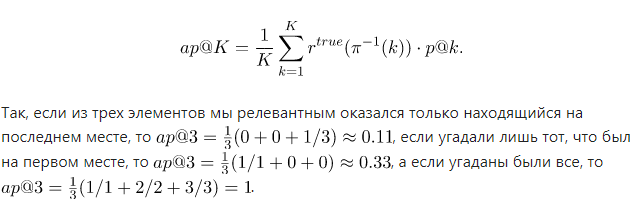

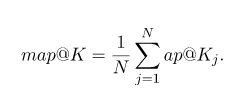

In [22]:
# Average precision at K
APaK = lambda marks: (1/len(marks)) * sum([marks[index-1]* sum(marks[:index]) / index for index in range(1, len(marks)+1)])

# Mean average precision at K
MAPaK = lambda answers, N: (1/len(answers)) * sum([APaK(marks[:N]) for marks in answers])

In [23]:
print('VSM scores:')
print(f"MAP@1: {MAPaK(markup_vsm, 1)}")
print(f"MAP@5: {MAPaK(markup_vsm, 5)}")
print(f"MAP@10: {MAPaK(markup_vsm, 10)}")
print(f"MAP@15: {MAPaK(markup_vsm, 15)}")

VSM scores:
MAP@1: 0.6000000000000001
MAP@5: 0.5593333333333333
MAP@10: 0.5717142857142857
MAP@15: 0.5473412698412699


In [24]:
print('BM25 scores:')
print(f"MAP@1: {MAPaK(markup_bm25, 1)}")
print(f"MAP@5: {MAPaK(markup_bm25, 5)}")
print(f"MAP@10: {MAPaK(markup_bm25, 10)}")
print(f"MAP@15: {MAPaK(markup_bm25, 15)}")

BM25 scores:
MAP@1: 0.4
MAP@5: 0.4546666666666667
MAP@10: 0.43434126984126986
MAP@15: 0.4328689273689274


## Метрика NDCG

Использованные формулы:
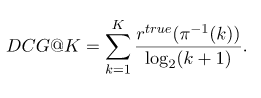

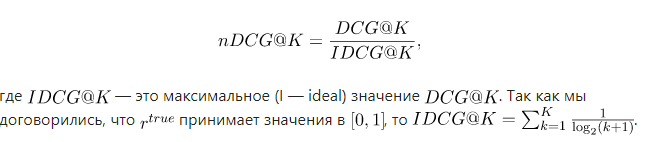

In [25]:
# Discounted Cumulative Gain at K
DCGaK = lambda marks: sum([marks[index-1] / np.log2(1 + index) for index in range(1, len(marks)+1)])

# Ideal discounted Cumulative Gain at K
IDCGaK = lambda marks: sum([1 / np.log2(1 + index) for index in range(1, len(marks)+1)])

# Normalized Discounted Cumulative Gain at K
NDCG = lambda answers, N: sum([DCGaK(marks[:N]) / IDCGaK(marks[:N]) for marks in answers])

In [26]:
print('VSM scores:')
print(f"NDCG@1: {NDCG(markup_vsm, 1)}")
print(f"NDCG@5: {NDCG(markup_vsm, 5)}")
print(f"NDCG@10: {NDCG(markup_vsm, 10)}")
print(f"NDCG@15: {NDCG(markup_vsm, 15)}")

VSM scores:
NDCG@1: 3.0
NDCG@5: 3.1695801026368082
NDCG@10: 3.319729868438214
NDCG@15: 3.2076345266685147


In [27]:
print('BM25 scores:')
print(f"NDCG@1: {MAPaK(markup_bm25, 1)}")
print(f"NDCG@5: {MAPaK(markup_bm25, 5)}")
print(f"NDCG@10: {MAPaK(markup_bm25, 10)}")
print(f"NDCG@15: {MAPaK(markup_bm25, 15)}")

BM25 scores:
NDCG@1: 0.4
NDCG@5: 0.4546666666666667
NDCG@10: 0.43434126984126986
NDCG@15: 0.4328689273689274
